In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
warnings.simplefilter("ignore")

# np.random.seed(1)
# random.seed(1)

import sys
sys.path.append("..")
sys.path.append("../shared")

from wednesdaySPEED import simulation

import numba
print(numba.__version__)

import itertools
import operator
import scipy as sc
from analytic_tools import *
import statsmodels.api as sm
import stochastic

0.53.1


In [2]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def visualiseNICE(G, P, N, S, X, D, T, U, C):
    fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(
        ncols=1, nrows=8, figsize=(12,12), sharex=True, gridspec_kw = 
        {'wspace':0, 'hspace':0.05, 'height_ratios':[2,2,1,1,1,1,1,1]}
    )
    im1 = ax1.imshow(G.T, cmap="bone", interpolation="None", aspect="auto")
    im4 = ax4.imshow(P.T, cmap="hot", interpolation="None", aspect="auto")
    amnwc = np.max(np.abs(N-initial_account_balance))  # absolute max net worth change
    vmin, vmax = initial_account_balance-amnwc, initial_account_balance+amnwc
    im5 = ax5.imshow(N.T, cmap="bwr", interpolation="None", aspect="auto", vmin=vmin, vmax=vmax)

    size = "15%"

    cax1 = make_axes_locatable(ax1).append_axes('right', size=size, pad=0.05)
    fig.colorbar(im1, cax=cax1, orientation='vertical')
    cax4 = make_axes_locatable(ax4).append_axes('right', size=size, pad=0.05)
    fig.colorbar(im4, cax=cax4, orientation='vertical')
    cax5 = make_axes_locatable(ax5).append_axes('right', size=size, pad=0.05)
    fig.colorbar(im5, cax=cax5, orientation='vertical')

    cax2 = make_axes_locatable(ax2).append_axes('right', size=size, pad=0.05)
    cax2.hist(S, orientation="horizontal", bins=np.linspace(np.min(S), np.max(S), len(S)//2))
    # cax2.hist(np.log10(S), orientation="horizontal", bins=np.logspace(np.log10(np.min(S)), np.log10(np.max(S)), len(S)//2))
    # cax2.set_xscale("log")
    # cax2.set_yscale("log")
    cax2.get_xaxis().set_visible(False)
    cax2.get_yaxis().set_visible(False)

    cax3 = make_axes_locatable(ax3).append_axes('right', size=size, pad=0.05)
    cax3.hist(X, orientation="horizontal", bins=np.linspace(np.min(X), np.max(X), len(X)//5))
    cax3.get_xaxis().set_visible(False)
    cax3.get_yaxis().set_visible(False)

    cax6 = make_axes_locatable(ax6).append_axes('right', size=size, pad=0.05)
    cax6.get_xaxis().set_visible(False)
    cax6.get_yaxis().set_visible(False)
    cax7 = make_axes_locatable(ax7).append_axes('right', size=size, pad=0.05)
    cax7.get_xaxis().set_visible(False)
    cax7.get_yaxis().set_visible(False)
    cax8 = make_axes_locatable(ax8).append_axes('right', size=size, pad=0.05)
    cax8.get_xaxis().set_visible(False)
    cax8.get_yaxis().set_visible(False)

    # for ax in (ax2,ax3):
    #     cax = make_axes_locatable(ax).append_axes('right', size=size, pad=0.05)
    #     # cax.axis('off')

    ##ax2.set_yscale("log")
    ax2.plot(S, label="S")
    Ws = [25]
    for W in Ws:
        ax2.plot(np.arange(W-1, len(S)), moving_average(S, W), label=f"MA{W}")
    ax2.grid(alpha=0.4)
    # ax2.legend(ncol=len(Ws)+1)

    ax3.bar(np.arange(len(X)), X)
    ax3.grid(alpha=0.4)

    # if D.shape[1] < 25:
    ax6.plot(np.mean(D[0],axis=1), color="C0", alpha=1, label="CA")
    ax6.plot(np.mean(D[1],axis=1), color="C1", alpha=1, label="momentum")
    ax6.plot(np.mean(D[2],axis=1), color="C2", alpha=1, label="invert")
    ax6.plot(np.max(D[0],axis=1), ":", color="C0", alpha=1, label="CA")
    ax6.plot(np.max(D[1],axis=1), ":", color="C1", alpha=1, label="momentum")
    ax6.plot(np.max(D[2],axis=1), ":", color="C2", alpha=1, label="invert")
    ax6.plot(np.min(D[0],axis=1), "--", color="C0", alpha=1, label="CA")
    ax6.plot(np.min(D[1],axis=1), "--", color="C1", alpha=1, label="momentum")
    ax6.plot(np.min(D[2],axis=1), "--", color="C2", alpha=1, label="invert")
    # ax6.plot(np.mean(D,axis=1), color="black", alpha=1)
    ax6.grid(alpha=0.4)
    # ax6.legend()


    ax7.set_yscale("symlog")
    ax7.plot(T, label="stack")
    ax7.plot(U, label="called shares")
    ax7.grid(alpha=0.4)
    ax7.legend()

    # if D.shape[1] < 25:
    #     ax6.plot(D, color="black", alpha=0.3)
    # ax6.plot(np.mean(D,axis=1), color="black", alpha=1)
    ax8.imshow(C.T, cmap="binary", interpolation="None", aspect="auto")
    # ax6.grid(alpha=0.4)
    
    ax8.set_xlabel("time")
    # ax2.set_ylabel("standardised log returns")
    ax2.set_ylabel("close price")
    ax1.set_ylabel("agents")
    ax3.set_ylabel("log return")
    ax4.set_ylabel("portfolio")
    ax5.set_ylabel("net worth")
    ax6.set_ylabel("influence (I)")
    ax7.set_ylabel("stack")
    ax8.set_ylabel("margin calls")

    # fig.colorbar(im, cax=ax4)
    
    plt.tight_layout()
    # plt.savefig("tmp.png", dpi=300)
    plt.show()

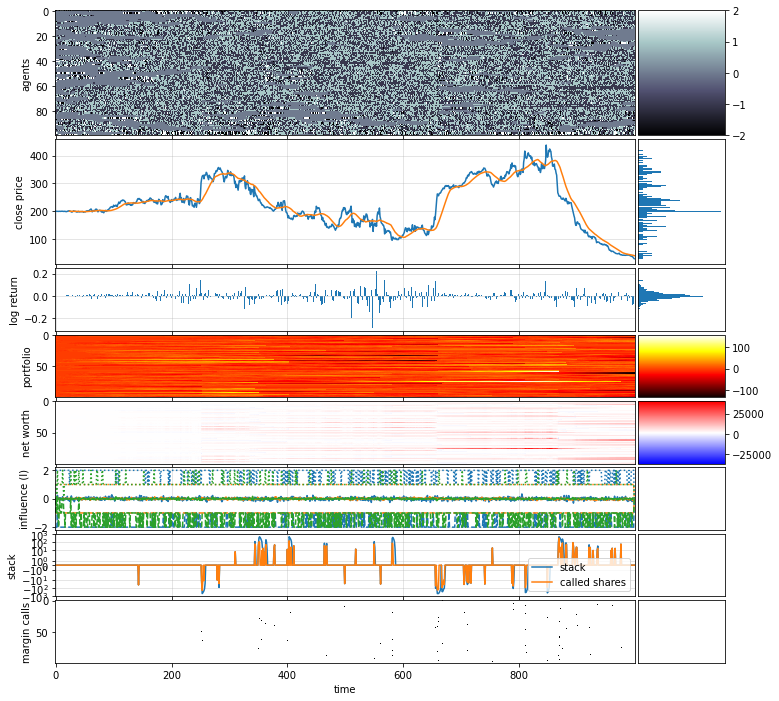

In [3]:
G,P,N,S,X,D,T,U,C, initial_account_balance = simulation(trigger = False, bound = True, pd = 0.05, pe = 0.01,
                    ph = 0.0485, pa = 0.3, N0 = 1000, N1 = 100, A = 1.8, a=2*1.8, h=1, 
                    pi1 = 0.5, pi2 = 0.3, pi3 = 0.2)
visualiseNICE(G, P, N, S, X, D, T, U, C)

## Eigenvalues of the correlation matrices

Complexity rises from nonlinearity. Since correlation matrix implies linearity, analyzing the eigenvalues of the correlation matrix at each time step might be helpful.

In [4]:
import seaborn as sns
from scipy import linalg

In [5]:
G_df = pd.DataFrame(G)

Extract two adjacent columns from the G matrix (two consecutive time steps).

Possible alternative: try two columns further apart?

In [41]:
def corr_eig(G):
    t = np.arange(len(G)-1)

    eig1 = []
    eig2 = []
    eig3 = []
    eig4 = []
    eig5 = []
    eig6 = []
    eig7 = []
    eig8 = []

    for i in range(len(G)-1):
        G_df_2col = G_df.iloc[i:i+2,:]
        corr_mat = G_df_2col.corr().fillna(0).to_numpy()
        eig = linalg.eigvals(corr_mat)
        eig1.append(eig[0])
        eig2.append(eig[1])
        eig3.append(eig[2])
        eig4.append(eig[3])
        eig5.append(eig[4])
        eig6.append(eig[5])
        eig7.append(eig[6])
        eig8.append(eig[7])

    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('t')
    ax1.set_ylabel('Eigenvalue', color=color)
    ax1.plot(t, np.array(eig4)**4, color=color, alpha=0.3) # The fourth eigenvalue
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title('4th eigenvalue of the correlation matrix')

    ax2 = ax1.twinx()

    color = 'tab:orange'
    ax2.set_ylabel('Stock price', color=color)
    ax2.plot(t, S[1:len(S)], color=color, alpha=0.6)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()

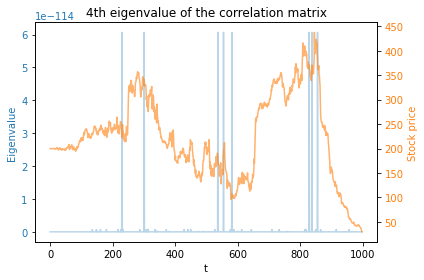

In [42]:
corr_eig(G)

## Antropy
https://raphaelvallat.com/antropy/build/html/index.html

### Lempel-Ziv (LZ) complexity of (binary) sequence
In this case not necessarily 'binary'. The traders in the system take three spin states. By taking the absolute value, it can be reduced to two states 0 and 1, resulting in a binary sequence.

The LZ complexity measure is related to Kolmogorov complexity. 

https://en.wikipedia.org/wiki/Lempel-Ziv_complexity

**Kolmogorov complexity of an object**, is the length of a shortest computer program that produces the object as output. **Lempel-Ziv complexity** corresponds to the number of iterations needed to finish the sequence search procedure (refere to Wikipedia).

--> The smaller the LZ complexity value, the less complex the sequence is.

--> Interpretation: The stock market bubbles/crashes in this (pseudo-)CA model result from the collective behavior of clusters of traders. If at any single time point, the sequence which describes the spin directions of the trader can be produced by a small program (low LZ complexity value), it is likely that a large group of traders share the same buying/selling behavior. Thus, by looking at the *dips* (not quantitatively compared to any baseline but just the general shape of the complexity measure), bubbles/crashes can be expected.

--> Limitations (for both eigenvalue and LZ complexity): One cannot tell whether the herd behavior drives towards a bubble OR a crash.

In [8]:
from antropy import lziv_complexity

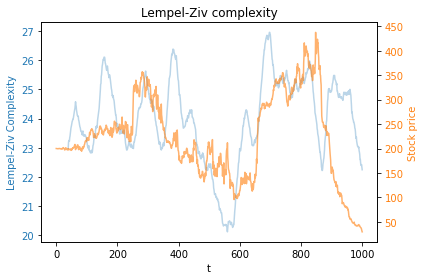

In [43]:
cplx = []
window = 40 # To smooth out the LZ complexity using moving average
t = np.arange(len(G))

for i in range(len(G)):
    cplx.append(lziv_complexity(G[i], normalize=False))

ma_cplx = moving_average(cplx, window)
    
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('t')
ax1.set_ylabel('Lempel-Ziv Complexity', color=color)
ax1.plot(t[window-1:len(G)], ma_cplx, color=color, alpha=0.3)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Lempel-Ziv complexity')

ax2 = ax1.twinx()

color = 'tab:orange'
ax2.set_ylabel('Stock price', color=color)
ax2.plot(t, S, color=color, alpha=0.6)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

=================================================================

_Now I'm just playing around with the fractal dimension functions in Antropy library. Not sure about the justification yet, but might be somewhat related to the multifractal analysis._

=================================================================

### Higuchi Fractal Dimension

Guess: A higher multifractality measure indicates higher complexity. So before emergent behavior (bubbles/crashes), the fractal dimension increases.

In [44]:
import antropy as ant

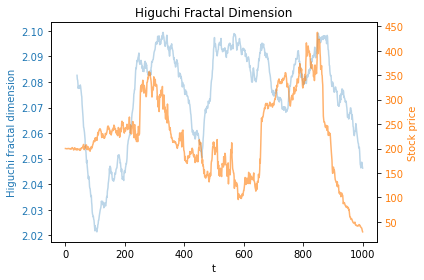

In [60]:
higuchi = []
window = 40 # To smooth out the LZ complexity using moving average
t = np.arange(len(G))

for i in range(len(G)):
    higuchi.append(ant.higuchi_fd(G[i], kmax=20))
ma_higuchi = moving_average(higuchi, window)
    
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('t')
ax1.set_ylabel('Higuchi fractal dimension', color=color)
ax1.plot(t[window-1:len(G)], ma_higuchi, color=color, alpha=0.3) # The fourth eigenvalue
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Higuchi Fractal Dimension')

ax2 = ax1.twinx()

color = 'tab:orange'
ax2.set_ylabel('Stock price', color=color)
ax2.plot(t, S, color=color, alpha=0.6)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

### Katz Fractal Dimension

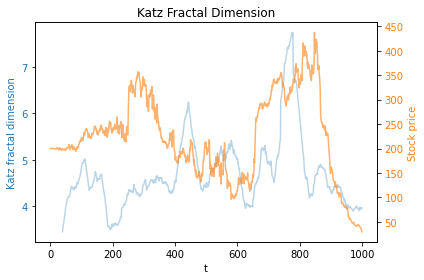

In [63]:
katz = []
window = 40 # To smooth out the LZ complexity using moving average
t = np.arange(len(G))

for i in range(len(G)):
    katz.append(ant.katz_fd(G[i]))
ma_katz = moving_average(katz, window)
    
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('t')
ax1.set_ylabel('Katz fractal dimension', color=color)
ax1.plot(t[window-1:len(G)], ma_katz, color=color, alpha=0.3) # The fourth eigenvalue
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Katz Fractal Dimension')

ax2 = ax1.twinx()

color = 'tab:orange'
ax2.set_ylabel('Stock price', color=color)
ax2.plot(t, S, color=color, alpha=0.6)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

### Petrosian Fractal Dimension

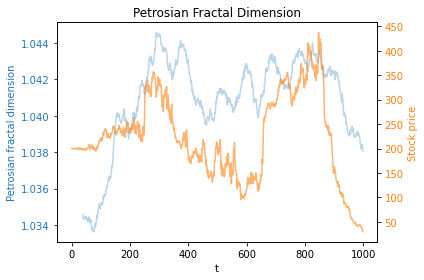

In [66]:
petro = []
window = 40 # To smooth out the LZ complexity using moving average
t = np.arange(len(G))

for i in range(len(G)):
    petro.append(ant.petrosian_fd(G[i]))
ma_petro = moving_average(petro, window)
    
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('t')
ax1.set_ylabel('Petrosian fractal dimension', color=color)
ax1.plot(t[window-1:len(G)], ma_petro, color=color, alpha=0.3) # The fourth eigenvalue
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Petrosian Fractal Dimension')

ax2 = ax1.twinx()

color = 'tab:orange'
ax2.set_ylabel('Stock price', color=color)
ax2.plot(t, S, color=color, alpha=0.6)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

#### Putting the fractal dimension plots together

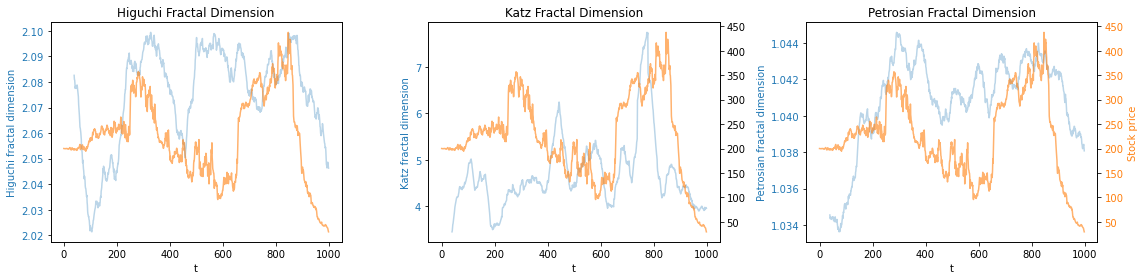

In [78]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[16,4])

# Higuchi fractal dimension
color = 'tab:blue'
ax1.set_xlabel('t')
ax1.set_ylabel('Higuchi fractal dimension', color=color)
ax1.plot(t[window-1:len(G)], ma_higuchi, color=color, alpha=0.3) # The fourth eigenvalue
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Higuchi Fractal Dimension')

ax4 = ax1.twinx()

color = 'tab:orange'
ax4.plot(t, S, color=color, alpha=0.6)
ax4.set_yticks([])

# Katz fractal dimension
color = 'tab:blue'
ax2.set_xlabel('t')
ax2.set_ylabel('Katz fractal dimension', color=color)
ax2.plot(t[window-1:len(G)], ma_katz, color=color, alpha=0.3) # The fourth eigenvalue
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_title('Katz Fractal Dimension')

ax5 = ax2.twinx()

color = 'tab:orange'
ax5.plot(t, S, color=color, alpha=0.6)
ax4.set_yticks([])

# Petrosian fractal dimension
color = 'tab:blue'
ax3.set_xlabel('t')
ax3.set_ylabel('Petrosian fractal dimension', color=color)
ax3.plot(t[window-1:len(G)], ma_petro, color=color, alpha=0.3) # The fourth eigenvalue
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_title('Petrosian Fractal Dimension')

ax6 = ax3.twinx()

color = 'tab:orange'
ax6.set_ylabel('Stock price', color=color)
ax6.plot(t, S, color=color, alpha=0.6)
ax6.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()